# Demonstration of Tehom's capabilities

This notebook shows how to display downloaded data and sample it as machine learning
training data.  It requires some AIS and acoustic data be downloaded prior to running.
Prior to running this notebook, take the following steps:
1. Create [Ocean Networks Canada account](https://data.oceannetworks.ca/Login?service=https://data.oceannetworks.ca/LandingPage)
and get your API token [here](https://data.oceannetworks.ca/Profile#api_tab>)
1. Run `tehom.downloads.save_user_token(<your token>)`
1. Run ```tehom.downloads.download_ais_data(2016, 6, 9)```
1. Run 

In [1]:
import pandas as pd

import tehom.downloads as td

## Identifying data
This section describes how to interrogate which acoustic data is available for download
and which ship label/acoustic data have already been downloaded and are ready for
sampling.
By assumption, all months of AIS (ship label) data are available to download.  However, 
ONC (acoustic) data is only available during certain periods, varying by hydrophone.  

This section is divided into functions that return code objects (lists, DataFrames, etc)
and the graphical `show_data()` function.
### Code objects
The `get_ais_downloads()` function returns a list of AIS downloads. Each record is a
tuple of (year, month, [UTM zone](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)).
Most ONC data is available in UTM zones 9 and 10

In [2]:
td.get_ais_downloads()

[(2016, 6, 9)]

The `get_audio_availability()` function lists the hydophone deployments as a pandas
DataFrame.  
Important columns are 
* `deviceCode` (hydrophone name)
* `begin` (when hydrophone was deployed)
* `end` (when hydrophone was removed/relocated)
* `lat` (latitude)
* `lon` (longitude)


In [3]:
td.get_audio_availability()

Requesting URL:
https://data.oceannetworks.ca/api/deployments?deviceCategoryCode=HYDROPHONE&method=get&token=f32ee0a7-1824-4e49-b695-35d723419d3b
Web Service response time: a second


,begin,depth,deviceCategoryCode,deviceCode,end,hasDeviceData,heading,lat,locationCode,lon,pitch,roll,zone
1,2009-09-11 00:27:51+00:00,982.4,HYDROPHONE,NAXYS_HYD_007,2010-05-16 13:49:01+00:00,True,NaN,48.316732,BACAX,-126.050142,NaN,NaN,9
2,2010-05-17 17:33:14+00:00,981.0,HYDROPHONE,NAXYS_HYD_007,2011-07-14 06:28:04+00:00,True,NaN,48.316758,BACAX,-126.050183,NaN,NaN,9
3,2018-06-22 03:05:27+00:00,647.0,HYDROPHONE,ICLISTENHF1252,2019-09-17 01:11:56+00:00,True,NaN,48.345900,BACND,-126.157938,NaN,NaN,9
4,2019-09-17 01:11:56+00:00,643.0,HYDROPHONE,ICLISTENHF1252,2020-06-01 21:37:15+00:00,True,NaN,48.345773,BACND,-126.157685,NaN,NaN,9
10,2016-06-16 05:18:32+00:00,394.0,HYDROPHONE,ICLISTENHF1251,2018-07-01 01:48:20+00:00,True,NaN,48.426393,BACUS.H1,-126.174394,NaN,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,2011-07-03 15:00:00+00:00,170.0,HYDROPHONE,IOS3HYDARR03,2011-12-11 23:30:00+00:00,True,NaN,49.000000,SGE.H1,-123.000000,NaN,NaN,10
168,2011-12-11 21:00:00+00:00,170.0,HYDROPHONE,ICHYDROPHONE203,2012-08-09 21:00:00+00:00,True,NaN,49.042422,SGE.H2,-123.317143,NaN,NaN,10
169,2021-03-25 16:52:01+00:00,110.0,HYDROPHONE,ICLISTENAF2556,2021-09-08 20:58:15+00:00,True,NaN,49.084384,USDDL,-123.330335,NaN,NaN,10
170,2022-03-11 20:42:58+00:00,112.0,HYDROPHONE,ICLISTENAF2556,2022-09-26 00:04:19+00:00,True,NaN,49.084282,USDDL,-123.330795,NaN,NaN,10


Acoustic recordings are not available during all deployments and intermittently
available in others.  To discover periods with contiguous acoustic data, tehom would
have to:
1. Query the ONC server for a list of all acoustic files
2. Download them
3. open the files to read the length
4. concatenate all the intervals appropriately.
Rather than do steps 2 and 3, tehom assumes all files are 5 min long (300 sec).  This is
usually true, but in odd cases causes wrong intervals.  We call this process
"certifying" data availability.  Despite skipping steps 2 and 3, the process still takes
a long time, so the funciton `certify_audio_availability()` stores the result locally,
saving progress in a pickle along the way.  This allows you to interrupt the function
and resume it later.


Note: When downloading acoustic files during an interval, it is not necessary to choose
exact times to bookend the data.  ONC servers find the correct files in a given
interval, so deployment intervals and certified intervals are just guides for users.


Uncomment, run, and then stop the following cell after a certain amount of time has
passed:

In [4]:
# td.certify_audio_availability()

Inspect the certified list to see what deployments have been fully certified:

In [5]:
from tehom import _persistence
_persistence.load_audio_availability_progress().tail()

,deviceCode,begin,depth,deviceCategoryCode,end,hasDeviceData,heading,lat,locationCode,lon,pitch,roll,zone
14,ICLISTENHF1251,2014-05-07 20:59:04+00:00,391.0,HYDROPHONE,2015-09-17 02:57:16+00:00,True,NaN,48.426363,BACUS,-126.174397,NaN,NaN,9
15,NAXYS_02345_P008,2009-08-25 09:30:00+00:00,329.62,HYDROPHONE,2010-05-14 21:34:54+00:00,True,NaN,48.427253,BACVP,-126.174095,2.235718,-1.477661,9
16,NAXYS_HYD_052,2012-05-28 15:45:00+00:00,329.62,HYDROPHONE,2013-05-19 18:24:00+00:00,True,NaN,48.427373,BACVP,-126.174127,2.235718,-1.477661,9
17,ICLISTENHF1354,2022-10-04 22:10:00+00:00,25.5,HYDROPHONE,2022-12-06 02:35:12.439151+00:00,True,NaN,49.300718,BIIP,-123.111097,NaN,NaN,10
18,ICLISTENHF1951,2020-10-22 21:45:00+00:00,38.0,HYDROPHONE,2022-06-17 00:09:00+00:00,True,NaN,49.30105,BIIP,-123.108889,NaN,NaN,10


Inspect the database for the calculated continuous data intervals.
There are a lot, because gaps of only a few milliseconds count as an interruption.
`tehom.downloads.OVERLAP_PRECISION` may be changed in future without deprecation.

In [2]:
td.get_audio_availability(certified=True).tail()

TypeError: '<' not supported between instances of 'str' and 'Timestamp'

### How to `show_data()` in plots
Instead of using code objects, tehom provides a graphical tool to display available data
for EDA in either a bar chart or surface map

Bar chart:

In [13]:
certified = td.get_audio_availability(certified=True)
certified.tail()

,deviceCode,begin,end,lat,lon
91505,NAXYS_HYD_052,2013-04-24 21:19:59.886000,2013-04-24 21:24:59.886000,48.427373,-126.174127
91506,NAXYS_HYD_052,2013-04-24 21:47:48.316000,2013-04-24 21:52:48.316000,48.427373,-126.174127
91507,NAXYS_HYD_052,2013-04-24 21:57:13.867000,2013-04-24 22:07:13.867000,48.427373,-126.174127
91508,NAXYS_HYD_052,2013-04-24 22:08:56.292000,2013-04-24 22:13:56.292000,48.427373,-126.174127
91509,NAXYS_HYD_052,2013-04-24 22:17:19.767000,2013-04-24 22:22:19.767000,48.427373,-126.174127


In [16]:
td.download_acoustics(
    ["ICLISTENHF1352"],
    begin="20160601",
    end="20160601T00:01:00",
    extension="mp3"
)

Requesting URL:
https://data.oceannetworks.ca/api/dataProductDelivery?dataProductCode=AD&extension=mp3&dateFrom=2016-06-20T00:00:00.000Z&dateTo=2016-06-20T00:01:00.000Z&deviceCode=ICLISTENHF1251&dpo_audioDownsample=-1&method=request&token=f32ee0a7-1824-4e49-b695-35d723419d3b

Error 400 - Bad Request: https://data.oceannetworks.ca/api/dataProductDelivery?dataProductCode=AD&extension=mp3&dateFrom=2016-06-20T00%3A00%3A00.000Z&dateTo=2016-06-20T00%3A01%3A00.000Z&deviceCode=ICLISTENHF1251&dpo_audioDownsample=-1&method=request&token=f32ee0a7-1824-4e49-b695-35d723419d3b
   Error 128: Missing Parameter.  Expected values: OD, LPF, HPF, All (parameter: dpo_hydrophoneDataDiversionMode)


Exception: ('The request failed with HTTP status 400.', {'errors': [{'errorCode': 128, 'errorMessage': 'Missing Parameter.  Expected values: OD, LPF, HPF, All', 'parameter': 'dpo_hydrophoneDataDiversionMode'}]})

Requesting URL:
https://data.oceannetworks.ca/api/deployments?deviceCategoryCode=HYDROPHONE&method=get&token=f32ee0a7-1824-4e49-b695-35d723419d3b
Web Service response time: 0.408 seconds


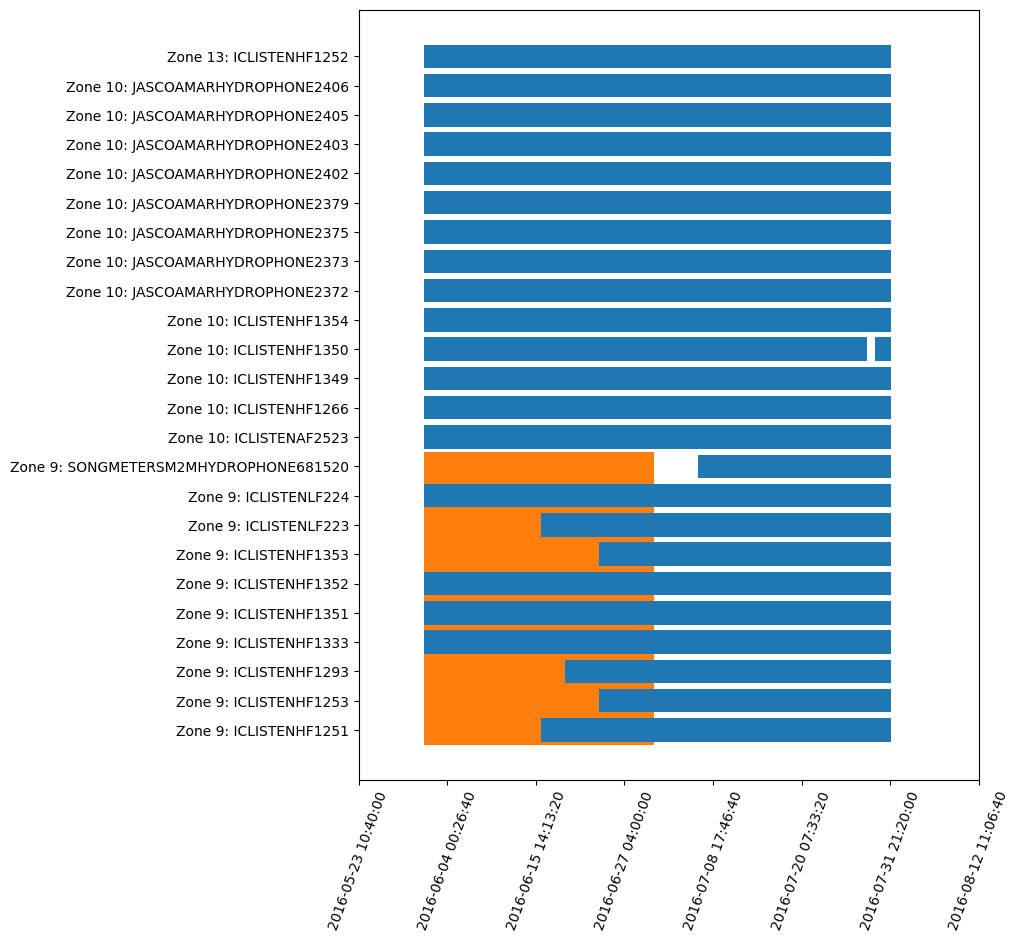

In [24]:
td.show_available_data(begin="2016-06", end="2016-08", style="bar")

Map:

In [22]:
onc = td.onc
td.download_acoustics(
        ["ICLISTENHF1252"], "20160101T12::00", "20160101T12:01:00", "mp3"
    )

Requesting URL:
https://data.oceannetworks.ca/api/dataProductDelivery?dataProductCode=AD&extension=wav&dateFrom=2016-01-01T12:00:00.000Z&dateTo=2016-01-01T12:01:00.000Z&deviceCode=ICLISTENHF1252&dpo_audioDownsample=-1&method=request&token=f32ee0a7-1824-4e49-b695-35d723419d3b
Web Service response time: 0.866 seconds
Request Id: 13343225
Estimated File Size: No estimated file size available.
Estimated Processing Time: No estimated processing time available.

   data product running....
   5 files generated for this data product
   complete


   Transferring (ICLISTENHF1252_20130901T000000.000Z_20210510T235900.000Z-hydrophoneCalibration.txt) to the FTP server....................

In [23]:
td.download_acoustics(
        ["ICLISTENHF1252"], "20160101T12:10:00", "20160101T12:11:00", "mp3"
    )

Requesting URL:
https://data.oceannetworks.ca/api/dataProductDelivery?dataProductCode=AD&extension=mp3&dateFrom=2016-01-01T12:10:00.000Z&dateTo=2016-01-01T12:11:00.000Z&deviceCode=ICLISTENHF1252&dpo_audioDownsample=-1&method=request&token=f32ee0a7-1824-4e49-b695-35d723419d3b
Web Service response time: 0.468 seconds
Request Id: 13343227
Estimated File Size: No estimated file size available.
Estimated Processing Time: No estimated processing time available.

   data product running...
   1 files generated for this data product
   complete

